In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from official.nlp import optimization  # to create AdamW optimizer
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os

SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# set_global_determinism(seed=SEED) # Setting seed for a reproducible code.
print(f'Tensorflow Version: {tf.__version__}')

Tensorflow Version: 2.10.0


In [2]:
# Importing dataset
dataset = np.load('char_normalized_flatten_dataset.npz')
X = dataset['x']
Y = dataset['y']
print(X.shape)
print(Y.shape)

(230, 21504)
(230,)


In [3]:
# Since this work is trying to create a model that is robust to every user we will be
# Splitting the dataset with Scikit-Learn Train-Test split.
# Further work can test if diferent splitting techniques enhance performance of the model
# e.g split acording to subjects/labels

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=SEED)

print(f'''
X_train shape:{X_train.shape} -> Train Labels: {y_train.shape[0]}
X_test shape:{X_test.shape} -> Test Labels: {y_test.shape[0]}''')


X_train shape:(184, 21504) -> Train Labels: 184
X_test shape:(46, 21504) -> Test Labels: 46


In [4]:
# Veriffing label distribution of train and test samples
display('Train Label distribution', pd.DataFrame(y_train, columns=['label']).groupby(['label'])['label'].count())
display('Test Label distribution', pd.DataFrame(y_test, columns=['label']).groupby(['label'])['label'].count())

'Train Label distribution'

label
0.0    19
1.0    17
2.0    19
3.0    19
4.0    20
5.0    18
6.0    18
7.0    19
8.0    17
9.0    18
Name: label, dtype: int64

'Test Label distribution'

label
0.0    4
1.0    6
2.0    4
3.0    4
4.0    3
5.0    5
6.0    5
7.0    4
8.0    6
9.0    5
Name: label, dtype: int64

In [5]:
# Creating our Transformer from a pre-trained model Transfer-Learn
## Based on https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb#scrollTo=JuxDkcvVIoev

# TensorFlow models and layers in transformers accept two formats as input:
# having all inputs as keyword arguments (like PyTorch models), or
# having all inputs as a list, tuple or dict in the first positional argument.

from keras.utils.np_utils import to_categorical   

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 10

y_train = to_categorical(y_train, num_classes=10, dtype='int')
y_test = to_categorical(y_test, num_classes=10, dtype='int')

In [6]:
train_features = tf.data.Dataset.from_tensor_slices(X_train)
train_labels = tf.data.Dataset.from_tensor_slices(y_train)
train_labels = train_labels.map(lambda x: tf.reshape(x,[1,10]))
train_ds = zip(train_features, train_labels)

test_features = tf.data.Dataset.from_tensor_slices(X_test)
test_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_labels = test_labels.map(lambda x: tf.reshape(x, [1,10]))
test_ds = zip(test_features,  test_labels)

In [7]:
## First pair of our dataset
[x for x in test_ds][0]

(<tf.Tensor: shape=(21504,), dtype=float64, numpy=
 array([ 1.90602193,  1.65093846,  0.0327983 , ..., -0.03829784,
        -1.17233507, -1.42353677])>,
 <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])>)

In [8]:
# Selecting a pre-trained model from Tensorflow Hub

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3'

In [9]:
# Create a preprocess layer

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [10]:
# Building our classifier

def build_classifier_model():
  EEG_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='EEG')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='Preprocessing')
  encoder_inputs = preprocessing_layer(EEG_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(10, activation='softmax', name='classifier')(net)
  return tf.keras.Model(EEG_input, net)

classifier_model = build_classifier_model()
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EEG (InputLayer)               [(None,)]            0           []                               
                                                                                                  
 Preprocessing (KerasLayer)     {'input_type_ids':   0           ['EEG[0][0]']                    
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

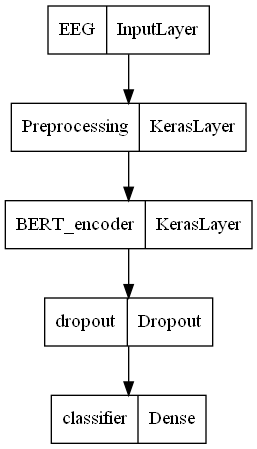

In [11]:
tf.keras.utils.plot_model(classifier_model)

In [12]:
EPOCHS = 5
steps_per_epoch = 184
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [13]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.metrics.Accuracy()

In [14]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [15]:
print(f'Training model with BERT_Multi_Cased_L-12_H-768_A-12')
history = classifier_model.fit(x = train_ds,
                               validation_data = test_ds,
                               epochs= EPOCHS)

Training model with BERT_Multi_Cased_L-12_H-768_A-12
Epoch 1/5


UnimplementedError: Graph execution error:

Detected at node 'model/Cast' defined at (most recent call last):
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Willian Oliveira\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Willian Oliveira\AppData\Roaming\Python\Python38\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Users\Willian Oliveira\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\Willian Oliveira\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Willian Oliveira\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Willian Oliveira\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Willian Oliveira\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Willian Oliveira\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\Willian Oliveira\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\Willian Oliveira\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Willian Oliveira\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "C:\Users\Willian Oliveira\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\Willian Oliveira\AppData\Roaming\Python\Python38\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Willian Oliveira\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Willian Oliveira\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Willian Oliveira\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Willian Oliveira\AppData\Local\Temp\ipykernel_4152\2758933308.py", line 2, in <module>
      history = classifier_model.fit(x = train_ds,
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\functional.py", line 649, in _run_internal_graph
      y = self._conform_to_reference_input(y, ref_input=x)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\functional.py", line 761, in _conform_to_reference_input
      tensor = tf.cast(tensor, dtype=ref_input.dtype)
Node: 'model/Cast'
Cast double to string is not supported
	 [[{{node model/Cast}}]] [Op:__inference_train_function_92411]